This notebook has my attempts at applying Bayesian parameter estimation onto the problem of source-level estimation. 

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np 
np.random.seed(100)
import pymc3 as pm
import pandas as pda
from scipy.special import jv as bessel_firstkind
from sympy import besselj, symbols, hankel2, legendre, sin, cos, summation, I, oo, diff, pi
from sympy import Abs, lambdify

In [2]:
theta_values = np.linspace(-np.pi/2,np.pi/2,100)
v_sound = 330 # m/s
freq = 50*10**3 # Hz
k_value = 2*np.pi/(v_sound/freq)
a_value = 5*10**-3

# choose another higher frequency
freq2 = 80*10**3
k_value2 =2*np.pi/(v_sound/freq2)


In [3]:
# from the online repo: https://github.com/thejasvibr/bat_beamshapes/

def absdivide_or_zero(a,b):
    try:
        out = abs(a/b)
    except:
        out = 0
    return out

def piston_in_infinite_baffle(theta, k=k_value, a=a_value):
    '''
    Generate predictions for the classic piston vibrating in an infinite baffle.

    Parameters
    ----------
    theta: 0<=float.<=2*pi
           The angle in azimuth/elevation at which the relative sound pressure is calculated.
           The relative soundpressure is calculated in comparison to the sound pressure level
           on-axis (0degrees/radians)
    k : float>0,optional
        The wavenumber of the sound (2*pi/wavelength)
    a : float>0, optional
        The diameter/radius(?) of the piston in m. 
    Returns
    --------
    rp_theta : float >=0.
               The relative sound pressure level at the given theta
    '''
    ka_sintheta = k*a*np.sin(theta)
    numerator = 2*bessel_firstkind(1, ka_sintheta)#2*bessel_firstkind(1, ka_sintheta)   
    try:
        rp_theta = np.apply_along_axis(absdivide_or_zero,0,numerator,ka_sintheta)        
    except:
        rp_theta = absdivide_or_zero(numerator,ka_sintheta)
    return rp_theta


#PIBF = lambdify(piston_in_infinite_baffle) 

db = lambda X: 20*np.log10(X)

In [4]:

rel_levels = np.zeros((theta_values.size,3))
rel_levels[:,0] = theta_values
rel_levels[:,1] = piston_in_infinite_baffle(theta_values)
rel_levels[:,2] = db(rel_levels[:,1])


In [5]:
%matplotlib inline

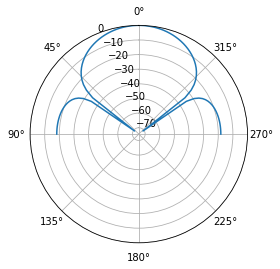

In [6]:
fig = plt.figure()
ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location("N")  # theta=0 at the top
plt.plot(rel_levels[:,0],rel_levels[:,2])

This is a coarse idea of the how beam-shape affects the calculated source-level of bat calls. Now, assuming this the beam-shape in general, let us sample a set of random-points, and generate a set of source-level measurements with beam-shape effects included. 

In [7]:
on_axis_SL = 100 # dB SPL re 20muPa at 1m -   the mean source-level
SL_sd = 1 # a +/- 1dB call-to-call standard deviation

random_thetas = np.random.choice(np.arange(rel_levels.shape[0]),25)
# generaate 
measured_SL = np.random.normal(on_axis_SL,SL_sd,random_thetas.size) + rel_levels[random_thetas,2]

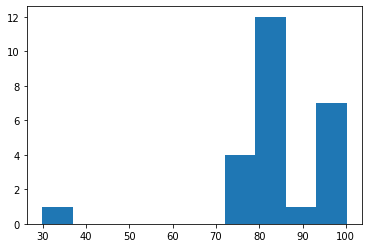

In [8]:
plt.figure()
plt.hist(measured_SL);

In [9]:
az.summary(measured_SL,kind='stats')

,mean,sd,hdi_3%,hdi_97%
x,83.242,13.681,75.693,100.166


<AxesSubplot:>

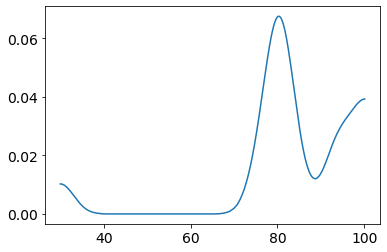

In [10]:
plt.figure()
az.plot_kde(measured_SL)

#### Beam-shape effects can have pretty strong results. 
As we can see above, the beam-shape effects could mean that the measured source-level will be generally under-estimated. The mean is ~82 dB SPL, while the range is between 60-100 dB SPL! 

#### How do we estimate the underlying mean source-level given all the prior information at hand?
$Measured\:level = On-axis\:source\:level - beam\:shape\:effect$ 

Here, the two parts are described by:

* $On-axis\:source\:level = N(\mu,\sigma)$
* $beam\:shape \:effect = f(\theta)$

In [11]:
def fn_measured_level(on_axis,theta):
    return on_axis-db(piston_in_infinite_baffle(theta))

In [12]:
m00 = pm.Model()
with m00:
    theta = pm.Uniform('theta',lower=0,upper=np.pi/2,shape=measured_SL.size)
    on_axis = pm.Normal('on_axis',mu=100,sigma=1,shape=measured_SL.size)
    sim = pm.Simulator('sim',fn_measured_level,params=(on_axis,theta),
                                   observed=measured_SL, epsilon=10)
    # -- delete the parallel=True as it always caused issues initially
    trace_lv = pm.sample_smc(draws=500,kernel="ABC")
    idata_lv = az.from_pymc3(trace_lv)
    

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.049
Stage:   1 Beta: 0.105
Stage:   2 Beta: 0.166
Stage:   3 Beta: 0.235
Stage:   4 Beta: 0.312
Stage:   5 Beta: 0.400
Stage:   6 Beta: 0.489
Stage:   7 Beta: 0.590
Stage:   8 Beta: 0.725
Stage:   9 Beta: 0.895
Stage:  10 Beta: 1.000
Stage:   0 Beta: 0.044
Stage:   1 Beta: 0.097
Stage:   2 Beta: 0.153
Stage:   3 Beta: 0.215
Stage:   4 Beta: 0.281
Stage:   5 Beta: 0.355
Stage:   6 Beta: 0.433
Stage:   7 Beta: 0.528
Stage:   8 Beta: 0.657
Stage:   9 Beta: 0.818
Stage:  10 Beta: 1.000


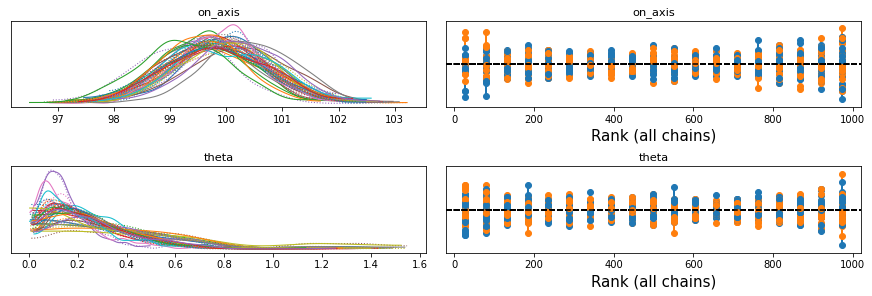

In [13]:
az.plot_trace(idata_lv, kind="rank_vlines");

In [14]:
out_data = idata_lv.to_dataframe()

In [15]:
r = az.summary(trace_lv,kind='stats',hdi_prob=0.89)

/home/autumn/anaconda3/envs/statsre/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [16]:
theta_summary = r.loc['theta[0]':,:]
theta_summary['hdi_width'] = theta_summary['hdi_94.5%']-theta_summary['hdi_5.5%']
theta_summary['hdiwidth_deg'] = np.degrees(theta_summary['hdi_width'])
theta_summary

<ipython-input-16-544a98573ba9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theta_summary['hdi_width'] = theta_summary['hdi_94.5%']-theta_summary['hdi_5.5%']
<ipython-input-16-544a98573ba9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theta_summary['hdiwidth_deg'] = np.degrees(theta_summary['hdi_width'])


,mean,sd,hdi_5.5%,hdi_94.5%,hdi_width,hdiwidth_deg
theta[0],0.227,0.164,0.008,0.441,0.433,24.809073
theta[1],0.231,0.150,0.032,0.454,0.422,24.178819
theta[2],0.357,0.246,0.019,0.639,0.620,35.523383
theta[3],0.245,0.166,0.019,0.476,0.457,26.184171
theta[4],0.152,0.093,0.025,0.280,0.255,14.610424
theta[5],0.455,0.341,0.020,0.868,0.848,48.586821
theta[6],0.221,0.160,0.012,0.425,0.413,23.663157
theta[7],0.246,0.157,0.019,0.454,0.435,24.923664
theta[8],0.462,0.347,0.007,1.006,0.999,57.238484
theta[9],0.243,0.151,0.025,0.443,0.418,23.949636


What about the on-axis source-levels?

In [17]:
onaxis_summary = r.loc['on_axis[0]':'on_axis[24]',:]
onaxis_summary['hdi_width'] = onaxis_summary['hdi_94.5%']-onaxis_summary['hdi_5.5%']
onaxis_summary

<ipython-input-17-bf186442427d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onaxis_summary['hdi_width'] = onaxis_summary['hdi_94.5%']-onaxis_summary['hdi_5.5%']


,mean,sd,hdi_5.5%,hdi_94.5%,hdi_width
on_axis[0],100.020,0.772,98.783,101.228,2.445
on_axis[1],99.851,0.934,98.332,101.265,2.933
on_axis[2],99.757,0.844,98.470,101.153,2.683
on_axis[3],99.787,0.800,98.452,100.974,2.522
on_axis[4],99.510,0.853,98.078,100.770,2.692
on_axis[5],100.112,0.869,98.891,101.644,2.753
on_axis[6],99.943,0.881,98.464,101.296,2.832
on_axis[7],99.686,0.804,98.533,101.055,2.522
on_axis[8],100.061,0.864,98.747,101.442,2.695
on_axis[9],99.865,0.867,98.413,101.213,2.800


### Does the upper 90%ile issue help with source-level estimation?
We've seen that when we have recorded calls from +/- 90$^{\circ}$ of the on-axis direction, the mean SL has been estimated correctly, even though there is still an okay interval of about 3 dB. We can see however, that because any observed value can be reproduced by a very large combination of on-axis source-level and angle. The $\theta$ estimate intervals are *pretty* wide (~$\pm 40^{\circ}$) 

Even if $\theta$ can't be estimated all that well, does choosing the loudest-calls help in decreasing the highest density interval of the on-axis source-level?

In [18]:
louder_sls = measured_SL[measured_SL>np.quantile(measured_SL,0.9)]

In [19]:
louder_sls

array([100.16627914,  99.97834302,  98.75851708])

Here, in this case we are kind of lucky as the 90%ile has the true on-axis source level range in it. But we may not always be so lucky, especially if we have a smaller sample size. 

In [20]:
# simulate choosing the loudest calls - only the upper 10%ile of all calls are chosen 
# and the on-axis source-level estimated

m00 = pm.Model()
with m00:
    theta = pm.Uniform('theta',lower=0,upper=np.pi/2,shape=louder_sls.size)
    on_axis = pm.Normal('on_axis',mu=100,sigma=1,shape=louder_sls.size)
    sim = pm.Simulator('sim',fn_measured_level,params=(on_axis,theta),
                                   observed=louder_sls, epsilon=10)
    # -- delete the parallel=True as it always caused issues initially
    trace_lv = pm.sample_smc(draws=500,kernel="ABC")
    idata_lv = az.from_pymc3(trace_lv)
    

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.439
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.436
Stage:   1 Beta: 1.000


In [21]:
np.degrees(0.5)

28.64788975654116

In [22]:
loudest_summary = az.summary(idata_lv,kind='stats')
loudest_summary['hdi_width'] = np.abs(loudest_summary['hdi_3%']-loudest_summary['hdi_97%'])
loudest_summary

,mean,sd,hdi_3%,hdi_97%,hdi_width
on_axis[0],99.977,0.957,98.227,101.716,3.489
on_axis[1],99.964,1.017,98.037,101.827,3.790
on_axis[2],99.930,1.025,97.866,101.660,3.794
theta[0],0.460,0.385,0.002,1.359,1.357
theta[1],0.447,0.367,0.002,1.302,1.300
theta[2],0.433,0.370,0.001,1.313,1.312


In [23]:
np.degrees(1.2)

68.75493541569878

### Choosing the loudest calls does not lead to much better estimates of source-level


## Using beam-shapes at different frequencies to estimate on-axis source-levels
The challenge in estimating source-level using the beam-shape for one frequency is that the same measured source-level can be the result of multiple on-axis levels and angle of recording. What if we try to estimate on-axis levels by using two or more beam-shapes? Two or more beam-shapes come about in a call when there is either a harmonic or when the call itself is frequency-modulated (FM). 

In [24]:
multi_rel_levels = np.zeros((theta_values.size,3))
multi_rel_levels[:,0] = theta_values
multi_rel_levels[:,1] = db(piston_in_infinite_baffle(theta_values)) # beam shape for 50kHz
multi_rel_levels[:,2] = db(piston_in_infinite_baffle(theta_values,k=k_value2))# beam shape for 80 kHz


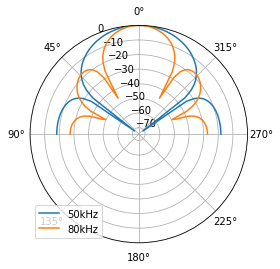

In [25]:
plt.figure()
ax0 = plt.subplot(111,projection='polar')
ax0.set_theta_zero_location("N")  # theta=0 at the top
plt.plot(multi_rel_levels[:,0],multi_rel_levels[:,1],label='50kHz')
plt.plot(multi_rel_levels[:,0],multi_rel_levels[:,2],label='80kHz')
plt.legend()

The 80kHz beam-shape is more directional, and shows more variation with off-axis angle. Let's see if including this other aspect of information helps us estimate the source-level and off-axis angle better. 

*We are assuming that the sound pressure levels are the same at both frequencies. This may not necessarily be true in case of harmonics, but is likely to be true in case of an FM sweep. Here we are simulating something that matches a typical FM micro-bat call.*

In [26]:
# choose a bunch of random angles of recording and recreate beam-shapes
on_axis_SL = 100 # dB SPL re 20muPa at 1m -   the mean source-level
SL_sd = 1 # a +/- 1dB call-to-call standard deviation

num_points = random_thetas.size
random_rows = np.random.choice(np.arange(multi_rel_levels.shape[0]),num_points)
random_angles = multi_rel_levels[random_rows,0]
off_axis_reduction = multi_rel_levels[random_rows,1:]
on_axis_levels = np.random.normal(on_axis_SL, SL_sd, num_points)
multifreq_measures = off_axis_reduction+np.column_stack((on_axis_levels,on_axis_levels))

Text(0.5, 0, 'Random off-axis angles')

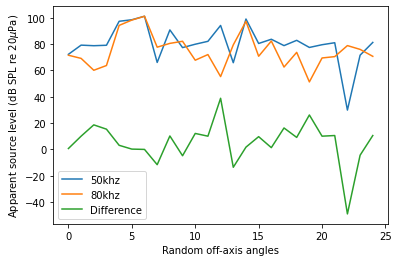

In [27]:
plt.figure()
plt.plot(multifreq_measures[:,0],label='50khz')
plt.plot(multifreq_measures[:,1],label='80khz')
plt.plot(multifreq_measures[:,0]-multifreq_measures[:,1],label='Difference')
plt.legend();plt.ylabel('Apparent source level (dB SPL re 20$\mu$Pa)');plt.xlabel('Random off-axis angles')


We see that there can be very huge differences in the apparent source-level as measured at various angles. For instance, the difference can be upto 40 dB! One lesson I can pick-up from this plot is that perhaps it's better to measure source-levels from lower frequencies than higher frequencies using peak-amplitude etc.

So, there can be strong differences in the apparent source-levels across different frequencies. This might actually help us estimate the $\theta$ and on-axis source-level better?

In [28]:
def fn_measured_level_2freq(on_axis,theta):
    '''Calculates the expected apparent source-level 
    for 50khz and 80kHz given the default piston size.
    '''
    f50khz = on_axis-db(piston_in_infinite_baffle(theta))
    f80khz = on_axis-db(piston_in_infinite_baffle(theta,k=k_value2))
    
    return np.column_stack((f50khz, f80khz))

In [29]:
m01 = pm.Model()
with m01:
    theta = pm.Uniform('theta',lower=0,upper=np.pi/2,shape=num_points)
    on_axis = pm.Normal('on_axis',mu=100,sigma=1,shape=num_points)
    sim = pm.Simulator('sim',fn_measured_level_2freq,params=(on_axis,theta),
                                   observed=multifreq_measures, epsilon=10)
    # -- delete the parallel=True as it always caused issues initially
    m01_trace = pm.sample_smc(draws=500,kernel="ABC")
    #idata_lv = az.from_pymc3(trace_lv)

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.019
Stage:   1 Beta: 0.039
Stage:   2 Beta: 0.058
Stage:   3 Beta: 0.078
Stage:   4 Beta: 0.098
Stage:   5 Beta: 0.123
Stage:   6 Beta: 0.149
Stage:   7 Beta: 0.179
Stage:   8 Beta: 0.214
Stage:   9 Beta: 0.263
Stage:  10 Beta: 0.319
Stage:  11 Beta: 0.391
Stage:  12 Beta: 0.485
Stage:  13 Beta: 0.614
Stage:  14 Beta: 0.784
Stage:  15 Beta: 1.000
Stage:   0 Beta: 0.018
Stage:   1 Beta: 0.037
Stage:   2 Beta: 0.059
Stage:   3 Beta: 0.079
Stage:   4 Beta: 0.101
Stage:   5 Beta: 0.124
Stage:   6 Beta: 0.149
Stage:   7 Beta: 0.179
Stage:   8 Beta: 0.213
Stage:   9 Beta: 0.256
Stage:  10 Beta: 0.304
Stage:  11 Beta: 0.369
Stage:  12 Beta: 0.451
Stage:  13 Beta: 0.560
Stage:  14 Beta: 0.704
Stage:  15 Beta: 0.881
Stage:  16 Beta: 1.000


In [30]:
mtrace_summary = az.summary(m01_trace,kind='stats',hdi_prob=0.89)


/home/autumn/anaconda3/envs/statsre/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


### Adding another beam-shape decreases $\theta$ estimation intervals


In [31]:
theta_summary = mtrace_summary.loc['theta[0]':,:]
theta_summary['hdi_width'] = theta_summary['hdi_94.5%']-theta_summary['hdi_5.5%']
theta_summary['hdiwidth_deg'] = np.degrees(theta_summary['hdi_width'])
theta_summary

<ipython-input-31-245cfa5cc629>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theta_summary['hdi_width'] = theta_summary['hdi_94.5%']-theta_summary['hdi_5.5%']
<ipython-input-31-245cfa5cc629>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theta_summary['hdiwidth_deg'] = np.degrees(theta_summary['hdi_width'])


,mean,sd,hdi_5.5%,hdi_94.5%,hdi_width,hdiwidth_deg
theta[0],0.125,0.071,0.019,0.223,0.204,11.688339
theta[1],0.111,0.075,0.009,0.207,0.198,11.344564
theta[2],0.118,0.064,0.025,0.204,0.179,10.255945
theta[3],0.131,0.067,0.031,0.223,0.192,11.000790
theta[4],0.171,0.124,0.021,0.342,0.321,18.391945
theta[5],0.216,0.151,0.018,0.402,0.384,22.001579
theta[6],0.226,0.161,0.026,0.422,0.396,22.689129
theta[7],0.134,0.074,0.020,0.236,0.216,12.375888
theta[8],0.137,0.090,0.012,0.260,0.248,14.209353
theta[9],0.130,0.087,0.016,0.251,0.235,13.464508


We see that the 89% highest density interval for all $\theta$ values is now reduced to at most 20$^{\circ}$ from a max of 40$^{\circ}$ before with only one beam-shape included. This is quite the drop in uncertainty. 

In [32]:
onaxis_summary = mtrace_summary.loc['on_axis[0]':'on_axis[24]',:]
onaxis_summary['hdi_width'] = onaxis_summary['hdi_94.5%']-onaxis_summary['hdi_5.5%']
onaxis_summary

<ipython-input-32-0addd4271c23>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onaxis_summary['hdi_width'] = onaxis_summary['hdi_94.5%']-onaxis_summary['hdi_5.5%']


,mean,sd,hdi_5.5%,hdi_94.5%,hdi_width
on_axis[0],99.634,0.796,98.397,100.846,2.449
on_axis[1],99.555,0.855,98.203,100.848,2.645
on_axis[2],99.584,0.881,98.033,100.773,2.740
on_axis[3],99.613,0.803,98.290,100.817,2.527
on_axis[4],99.763,0.919,98.423,101.290,2.867
on_axis[5],99.914,0.873,98.468,101.299,2.831
on_axis[6],99.796,0.859,98.421,101.078,2.657
on_axis[7],99.820,0.777,98.561,101.055,2.494
on_axis[8],99.769,0.842,98.504,101.221,2.717
on_axis[9],99.521,0.822,98.263,100.815,2.552


There is not much drop in the on-axis level uncertainty. The same ~3 dB interval remains as in the single beam-shape example.  Remember, we have maintained everything the same (sample size, on-axis level$\pm$sd), and the only new thing is the additional beam-shape information. 

## Summary
Measuring on-axis source-levels for bats flying in the field is no easy task. Even if the bat is flying towards the microphones, the call may not be directed at the mics straight away. In this notebook I have shown how explicitly modelling beam-shape effects increases the accuracy of on-axis source level estimation, when we include all calls - and not only the 'loudest' calls. Till now, researchers have used an upper percentile threshold to estimate the on-axis source levels. Using the approach outlined in this notebook, we can thus actually estimate the on-axis levels even with relatively faint calls.  

In [33]:
%load_ext watermark
%watermark -n -u -v -iv `b -w

Last updated: Sun Mar 14 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

numpy     : 1.19.5
arviz     : 0.11.0
pymc3     : 3.11.0
matplotlib: 3.3.4
pandas    : 1.2.1

Watermark: 2.1.0



In [34]:
import os


In [35]:
os.getcwd()

'/home/autumn/Documents/trying_out/me-statistical-rethinking/paramsims'